## Imports

In [52]:
import multiprocessing.pool
import sys
import os
import tensorflow as tf
import keras.backend as K
import h5py
import numpy as np
import imageio
import matplotlib.pyplot as plt
from pathlib import PurePath

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input, UpSampling2D
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import Callback
from functools import partial

print(tf.__version__)

2.1.0


## Parameters

In [13]:
LAMBDA=1
TARGET_SIZE = (383, 383)
BATCH_SIZE = 4
epochs = 2
target_layer = 1

content_image_path = "data/input/content.png"
style_image_path = "data/input/style.png"

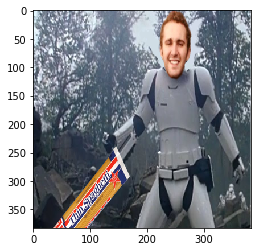

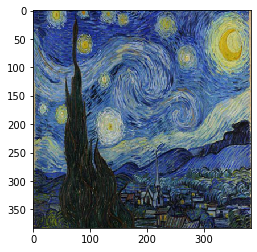

In [36]:
content_image = image.load_img(content_image_path)
content_image = content_image.resize(TARGET_SIZE)
content_image = image.img_to_array(content_image)
content_image_shape = content_image.shape
content_image = np.expand_dims(content_image, axis=0)
content_image = content_image[0]/255
plt.imshow(content_image)
plt.show()

style_image = image.load_img(style_image_path)
style_image = style_image.resize(TARGET_SIZE)
style_image = image.img_to_array(style_image)
style_image_shape = style_image.shape
style_image = np.expand_dims(style_image, axis=0)
style_image = style_image[0]/255
plt.imshow(style_image)
plt.show()

## Yihao Model

In [63]:
class VGG19AE(tf.keras.Model):
    def __init__(self, files_path):
        super(VGG19AE, self).__init__()
        #Load Model
        ModelBlock5 = tf.keras.models.load_model(str(PurePath(files_path, 'Block5_Model')), compile = False)
        #Get Each SubModel
        self.E5 = ModelBlock5.layers[0]
        self.D5 = ModelBlock5.layers[1]
        self.O5 = ModelBlock5.layers[2]
        ModelBlock4 = tf.keras.models.load_model(str(PurePath(files_path, 'Block4_Model')), compile = False)
        self.E4 = ModelBlock4.layers[0]
        self.D4 = ModelBlock4.layers[1]
        self.O4 = ModelBlock4.layers[2]
        ModelBlock3 = tf.keras.models.load_model(str(PurePath(files_path, 'Block3_Model')), compile = False)
        self.E3 = ModelBlock3.layers[0]
        self.D3 = ModelBlock3.layers[1]
        self.O3 = ModelBlock3.layers[2]
        ModelBlock2 = tf.keras.models.load_model(str(PurePath(files_path, 'Block2_Model')), compile = False)
        self.E2 = ModelBlock2.layers[0]
        self.D2 = ModelBlock2.layers[1]
        self.O2 = ModelBlock2.layers[2]
        ModelBlock1 = tf.keras.models.load_model(str(PurePath(files_path, 'Block1_Model')), compile = False)
        self.E1 = ModelBlock1.layers[0]
        self.O1 = ModelBlock1.layers[1]
    
    def wct(self, content, style, alpha=0.6, eps=1e-5):
        '''
        https://github.com/eridgd/WCT-TF/blob/master/ops.py
           Perform Whiten-Color Transform on feature maps using numpy
           See p.4 of the Universal Style Transfer paper for equations:
           https://arxiv.org/pdf/1705.08086.pdf
        '''
        
        # 1xHxWxC -> CxHxW
        content_t = np.transpose(np.squeeze(content), (2, 0, 1))
        style_t = np.transpose(np.squeeze(style), (2, 0, 1))

        # CxHxW -> CxH*W
        content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
        style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

        # Whitening transform
        mc = content_flat.mean(axis=1, keepdims=True)
        fc = content_flat - mc
        fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
        Ec, wc, _ = np.linalg.svd(fcfc)
        k_c = (wc > 1e-5).sum()
        Dc = np.diag((wc[:k_c]+eps)**-0.5)
        fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

        # Coloring transform
        ms = style_flat.mean(axis=1, keepdims=True)
        fs = style_flat - ms
        fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)
        Es, ws, _ = np.linalg.svd(fsfs)
        k_s = (ws > 1e-5).sum()
        Ds = np.sqrt(np.diag(ws[:k_s]+eps))
        fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)
        fcs_hat = fcs_hat + ms

        # Blend transform features with original features
        blended = alpha*fcs_hat + (1 - alpha)*(fc)

        # CxH*W -> CxHxW
        blended = blended.reshape(content_t.shape)
        # CxHxW -> 1xHxWxC
        blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)

        return np.float32(blended)

    def call(self, Image, training  = False):
        # Input should be 4D Tensor
        xo, I2 = Image
        x = self.E3(xo)
        style = self.E3(I2)
        #Add WCT Here
        x = self.wct(x,style)
        x = self.D3(x)
        x = self.O3(x)
        # Block 1 Donot have decoder because it don't contain Pooling and there are only one Conv layer.
#         x = self.E1(x)
#         x = self.O1(x)
        return tf.clip_by_value(tf.squeeze(x), 0, 1)

AE = VGG19AE('Model')

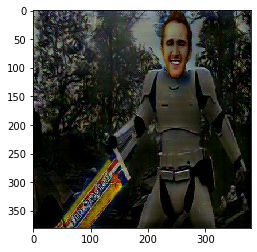

In [64]:
input_images = (tf.expand_dims(content_image, 0), tf.expand_dims(style_image, 0))
Out_image = AE(input_images)
plt.imshow(Out_image)
plt.show()

## NVIDIA's Photorealistic Smoothing
Found here: https://github.com/NVIDIA/FastPhotoStyle/blob/master/photo_smooth.py

In [ ]:
"""
Copyright (C) 2018 NVIDIA Corporation.    All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
from __future__ import division
import torch.nn as nn
import scipy.misc
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
from numpy.lib.stride_tricks import as_strided
from PIL import Image


class Propagator(nn.Module):
    def __init__(self, beta=0.9999):
        super(Propagator, self).__init__()
        self.beta = beta

    def process(self, initImg, contentImg):

        if type(contentImg) == str:
            content = scipy.misc.imread(contentImg, mode='RGB')
        else:
            content = contentImg.copy()
        # content = scipy.misc.imread(contentImg, mode='RGB')

        if type(initImg) == str:
            B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64) / 255
        else:
            B = scipy.asarray(initImg).astype(np.float64) / 255
            # B = self.
        # B = scipy.misc.imread(initImg, mode='RGB').astype(np.float64)/255
        h1,w1,k = B.shape
        h = h1 - 4
        w = w1 - 4
        B = B[int((h1-h)/2):int((h1-h)/2+h),int((w1-w)/2):int((w1-w)/2+w),:]
        content = scipy.misc.imresize(content,(h,w))
        B = self.__replication_padding(B,2)
        content = self.__replication_padding(content,2)
        content = content.astype(np.float64)/255
        B = np.reshape(B,(h1*w1,k))
        W = self.__compute_laplacian(content)
        W = W.tocsc()
        dd = W.sum(0)
        dd = np.sqrt(np.power(dd,-1))
        dd = dd.A.squeeze()
        D = scipy.sparse.csc_matrix((dd, (np.arange(0,w1*h1), np.arange(0,w1*h1)))) # 0.026
        S = D.dot(W).dot(D)
        A = scipy.sparse.identity(w1*h1) - self.beta*S
        A = A.tocsc()
        solver = scipy.sparse.linalg.factorized(A)
        V = np.zeros((h1*w1,k))
        V[:,0] = solver(B[:,0])
        V[:,1] = solver(B[:,1])
        V[:,2] = solver(B[:,2])
        V = V*(1-self.beta)
        V = V.reshape(h1,w1,k)
        V = V[2:2+h,2:2+w,:]
        
        img = Image.fromarray(np.uint8(np.clip(V * 255., 0, 255.)))
        return img

    # Returns sparse matting laplacian
    # The implementation of the function is heavily borrowed from
    # https://github.com/MarcoForte/closed-form-matting/blob/master/closed_form_matting.py
    # We thank Marco Forte for sharing his code.
    def __compute_laplacian(self, img, eps=10**(-7), win_rad=1):
            win_size = (win_rad*2+1)**2
            h, w, d = img.shape
            c_h, c_w = h - 2*win_rad, w - 2*win_rad
            win_diam = win_rad*2+1
            indsM = np.arange(h*w).reshape((h, w))
            ravelImg = img.reshape(h*w, d)
            win_inds = self.__rolling_block(indsM, block=(win_diam, win_diam))
            win_inds = win_inds.reshape(c_h, c_w, win_size)
            winI = ravelImg[win_inds]
            win_mu = np.mean(winI, axis=2, keepdims=True)
            win_var = np.einsum('...ji,...jk ->...ik', winI, winI)/win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)
            inv = np.linalg.inv(win_var + (eps/win_size)*np.eye(3))
            X = np.einsum('...ij,...jk->...ik', winI - win_mu, inv)
            vals = (1/win_size)*(1 + np.einsum('...ij,...kj->...ik', X, winI - win_mu))
            nz_indsCol = np.tile(win_inds, win_size).ravel()
            nz_indsRow = np.repeat(win_inds, win_size).ravel()
            nz_indsVal = vals.ravel()
            L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))
            return L

    def __replication_padding(self, arr,pad):
            h,w,c = arr.shape
            ans = np.zeros((h+pad*2,w+pad*2,c))
            for i in range(c):
                    ans[:,:,i] = np.pad(arr[:,:,i],pad_width=(pad,pad),mode='edge')
            return ans

    def __rolling_block(self, A, block=(3, 3)):
        shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
        strides = (A.strides[0], A.strides[1]) + A.strides
        return as_strided(A, shape=shape, strides=strides)